In [1]:
import os
import numpy as np

# Create a Spark Context
if os.name == 'nt':
    import findspark
    findspark.init(r"D:\Downloads\spark-2.2.1-bin-hadoop2.7")

from pyspark import SparkContext
sc = SparkContext.getOrCreate()


from src.stats import Standardize
from src.preprocess import cleanNHANESData
from src.DBSCAN import DBSCAN
from src.data_handler import Process
from src.data_handler import FeatureVector
from src.preprocess import FilterData
from src.preprocess import ReplaceFeature

raw_data = {}
demo_data={}



for year in ['2009','2011']:
    
    raw_data[year] = sc.textFile('./data/{0}_DR2TOT.csv'.format(year))
        

#Loading the NHANES demographic data of people from 2009 and 2011
for year in ['2009','2011']:
    
    demo_data[year]=sc.textFile('./data/{}_DEMO.csv'.format(year))



    
total = 0
for year_data in raw_data.values():
    total += year_data.count()
    
total_demo=0   
for year_data in demo_data.values():
    total_demo += year_data.count()
    
print('Total number of people_nutrient entries: {}'.format(total))
print('Total number of people_demo entries: {}'.format(total_demo))
#print(raw_data[year].take(2)[0:5])
# Load list of nutrient features we want from the raw dietary data
with open('./data/features.txt') as f:
    features = f.readlines()

features = [f.strip() for f in features]
Feat = features[0:]


with open('./data/features1.txt') as f1:
    features1 = f1.readlines()

features1 = [f.strip() for f in features1]
Feat1 = features1[0:]


print('List of features:\n', Feat1)
print('List of features:\n', Feat)

Total number of people_nutrient entries: 19593
Total number of people_demo entries: 20295
List of features:
 ['SEQN', 'RIDAGEYR', 'INDFMPIR', 'RIAGENDR']
List of features:
 ['SEQN', 'DR2TPROT', 'DR2TCARB', 'DR2TSUGR', 'DR2TFIBE', 'DR2TTFAT', 'DR1TPROT', 'DR1TCARB', 'DR1TSUGR', 'DR1TFIBE', 'DR1TTFAT']


In [2]:

def _KeyValue(x,size):
    i=0
    key=x[0]
    value=np.array(x[-size:],dtype='float32')
   
    return (key,value)


def JoinYears(data):
   
    concat_data = 0
    for value in data.values():
        if concat_data == 0:
            concat_data = value
        else:
            concat_data = concat_data.union(value)
    return concat_data



def preprocessData(data,features,size):
    #processing data ie remove the header, filling missing values with nan
    for key, rdd in data.items():
        data[key] = Process(rdd)
    
    
    #Selecting only the features that we need
    for key, value in data.items():
        header,rdd=value
        header,rdd=FeatureVector(rdd, header, features)
        data[key]=(header, rdd)
        
    #  Removing data with null values and making a key value pair
    for key, val in data.items():
        
        filt_temp=val[1].filter(lambda x:not any(np.isnan(x)))
        
        tempo= filt_temp.map(lambda x: _KeyValue(x,size))
        data[key]=tempo
        
    data=JoinYears(data)
    
    return data









In [3]:
#cleaning the people's nutrient data
size=len(Feat)-6
preproc_data=preprocessData(raw_data,Feat,size)

#cleaning the people's demographic data
size1=len(Feat1)-1
preproc_demo_data=preprocessData(demo_data,Feat1,size1)
print(preproc_data.take(5),'nutrient data')
print(preproc_demo_data.take(5),'demo data')
print(preproc_data.count(),'is the count of entire nutrients data ')
print(preproc_demo_data.count(),'is the count of entire demographic merged data ')

[(51624.0, array([ 95.48, 199.35,  77.79,  11.8 , 102.32], dtype=float32)), (51625.0, array([ 70.48, 262.88, 110.33,  12.4 ,  61.01], dtype=float32)), (51626.0, array([102.64, 193.39,  65.19,   8.6 , 110.34], dtype=float32)), (51627.0, array([ 79.61, 308.52, 130.14,  20.  , 101.24], dtype=float32)), (51628.0, array([ 38.81, 115.91,  69.23,   2.5 ,  42.78], dtype=float32))] nutrient data
[(51624.0, array([34.  ,  1.36,  1.  ], dtype=float32)), (51625.0, array([4.  , 1.07, 1.  ], dtype=float32)), (51626.0, array([16.  ,  2.27,  1.  ], dtype=float32)), (51627.0, array([10.  ,  0.81,  1.  ], dtype=float32)), (51628.0, array([60.  ,  0.69,  2.  ], dtype=float32))] demo data
15784 is the count of entire nutrients data 
18457 is the count of entire demographic merged data 


In [4]:
#sorting based on the income to poverty income ratio or gender or age 
def sortRich(rdd2):
    rdd3=[]
    if(rdd2[1][1]>=1):    #rdd2[1][0]>=25   #rdd2[1][2]==1 (male)  rdd2[1][1]>=1
        rdd3.append((rdd2[0],rdd2[1]))
        
    else:
       
        rdd3.append((0,rdd2[1]))
        
    return rdd3
    
def sortPoor(rdd2):
    rdd3=[]
    if(rdd2[1][1]<1):   ## and' rdd2[1][0]<=25  #rdd2[1][2]==2 (female) rdd2[1][1]<1
        
        rdd3.append((rdd2[0],rdd2[1]))
    else:
        rdd3.append((0,rdd2[1]))
        
    return rdd3


rich_rdd=preproc_demo_data.flatMap(sortRich)
poor_rdd=preproc_demo_data.flatMap(sortPoor)
print(rich_rdd.take(10))


print(poor_rdd.take(10))


[(51624.0, array([34.  ,  1.36,  1.  ], dtype=float32)), (51625.0, array([4.  , 1.07, 1.  ], dtype=float32)), (51626.0, array([16.  ,  2.27,  1.  ], dtype=float32)), (0, array([10.  ,  0.81,  1.  ], dtype=float32)), (0, array([60.  ,  0.69,  2.  ], dtype=float32)), (51629.0, array([26.  ,  1.01,  1.  ], dtype=float32)), (51630.0, array([49.  ,  1.91,  2.  ], dtype=float32)), (51631.0, array([1.  , 1.36, 2.  ], dtype=float32)), (51632.0, array([10.  ,  2.68,  1.  ], dtype=float32)), (51633.0, array([80.  ,  1.27,  1.  ], dtype=float32))]
[(0, array([34.  ,  1.36,  1.  ], dtype=float32)), (0, array([4.  , 1.07, 1.  ], dtype=float32)), (0, array([16.  ,  2.27,  1.  ], dtype=float32)), (51627.0, array([10.  ,  0.81,  1.  ], dtype=float32)), (51628.0, array([60.  ,  0.69,  2.  ], dtype=float32)), (0, array([26.  ,  1.01,  1.  ], dtype=float32)), (0, array([49.  ,  1.91,  2.  ], dtype=float32)), (0, array([1.  , 1.36, 2.  ], dtype=float32)), (0, array([10.  ,  2.68,  1.  ], dtype=float32)), 

In [5]:
#Joining the rdd's of nutrient vals and demo to sort poor and rich datasets
#print(preproc_data.take(5),"nutrient data")
print(preproc_data.count())



final_rich_rdd=preproc_data.join(rich_rdd)

final_poor_rdd=preproc_data.join(poor_rdd)
print(final_rich_rdd.take(5))
print(final_rich_rdd.count())
print(final_poor_rdd.take(5))
print(final_poor_rdd.count())

15784
[(51624.0, (array([ 95.48, 199.35,  77.79,  11.8 , 102.32], dtype=float32), array([34.  ,  1.36,  1.  ], dtype=float32))), (51656.0, (array([ 86.7 , 274.43, 125.91,  24.5 ,  40.74], dtype=float32), array([58.,  5.,  1.], dtype=float32))), (51664.0, (array([110.17, 303.35, 138.33,  28.1 , 127.1 ], dtype=float32), array([53.,  5.,  2.], dtype=float32))), (51672.0, (array([ 37.55, 162.24,  78.96,  12.2 ,  14.17], dtype=float32), array([27.  ,  2.04,  2.  ], dtype=float32))), (51680.0, (array([ 63.12, 193.45, 101.22,  18.2 ,  39.89], dtype=float32), array([60.  ,  2.59,  2.  ], dtype=float32)))]
10498
[(51640.0, (array([ 63.23, 237.02,  99.42,  10.3 ,  70.54], dtype=float32), array([17. ,  0.3,  1. ], dtype=float32))), (51648.0, (array([ 57.72, 131.82,  43.3 ,  32.2 ,  38.94], dtype=float32), array([28.  ,  0.09,  1.  ], dtype=float32))), (51736.0, (array([ 37.8 , 122.57,  50.76,   5.9 ,  35.63], dtype=float32), array([60.  ,  0.68,  2.  ], dtype=float32))), (51760.0, (array([ 45.1 ,

In [10]:
#Processing the data in a way that is feasible to perform DBSCAN 

def sortHere(demordd):
    
    demordd=(demordd[0],demordd[1][0])
    return demordd

rich_nutrient_data=final_rich_rdd.map(sortHere)
poor_nutrient_data=final_poor_rdd.map(sortHere)
print(rich_nutrient_data.take(5))
print(poor_nutrient_data.take(5))

#print(rich_nutrient.take(5))

[(51624.0, array([ 95.48, 199.35,  77.79,  11.8 , 102.32], dtype=float32)), (51656.0, array([ 86.7 , 274.43, 125.91,  24.5 ,  40.74], dtype=float32)), (51664.0, array([110.17, 303.35, 138.33,  28.1 , 127.1 ], dtype=float32)), (51672.0, array([ 37.55, 162.24,  78.96,  12.2 ,  14.17], dtype=float32)), (51680.0, array([ 63.12, 193.45, 101.22,  18.2 ,  39.89], dtype=float32))]
[(51640.0, array([ 63.23, 237.02,  99.42,  10.3 ,  70.54], dtype=float32)), (51648.0, array([ 57.72, 131.82,  43.3 ,  32.2 ,  38.94], dtype=float32)), (51736.0, array([ 37.8 , 122.57,  50.76,   5.9 ,  35.63], dtype=float32)), (51760.0, array([ 45.1 , 182.71,  81.4 ,   8.5 ,  54.6 ], dtype=float32)), (51864.0, array([ 59.54, 285.6 , 141.96,  10.  ,  57.82], dtype=float32))]


In [11]:
#Standardizing
##rich_nutrient=Standardize(rich_nutrient_data)
##poor_nutrient=Standardize(poor_nutrient_data)
rich_nutrient=rich_nutrient_data
poor_nutrient=poor_nutrient_data

#sampling so as to compare the clusteres
data_sample1 = rich_nutrient.sample(False, 0.50).persist()
#data_sample1=rich_nutrient

DBSCAN completed in 43 iterations
DBSCAN completed in 35 iterations


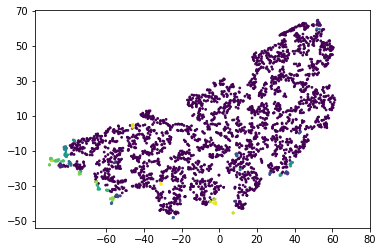

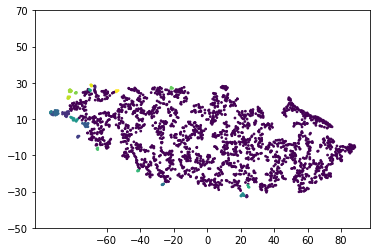

41 Clusters found with 53.39 %  data points clustered
22 Clusters found with 53.77 % data points clustered


In [13]:
#Plotting the cluster into 2d 

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

# Percent of data points clustered
def percentClustered(clusters, total):
    
    total_clusters= clusters.count()
    percentClustered=(total_clusters/total)*100
    return percentClustered
    
#counting the number of clusters
def clusterCount(clusters):
    return clusters.values().distinct().count()



def plotFoodClusters2D(clusters):
    # cluster IDS to color plotted clusters
    
    cluster_ids = clusters.keys().collect()
    unique_ids = np.unique(cluster_ids).tolist()
    cluster_ids = [unique_ids.index(i) for i in cluster_ids]
    #print(cluster_ids)
    
    # Reducing nutrient values to 2 dimensions with TSNE
    
    nutrient_values = clusters.values().collect()
    cluster_embedded = TSNE(n_components=2).fit_transform(nutrient_values)
    #cluster_zip=zip(*cluster_embedded,*nutrient_values)
    #i=0
    #while(i<10):
   
      
    X = cluster_embedded[:,0]
    Y = cluster_embedded[:,1]
    plt.scatter(X, Y, c=cluster_ids, s=3)
    plt.xticks(np.arange(-80,100,20))
    plt.yticks(np.arange(-50,80,20))
    #plt.xticks(np.arange(-100,100,20))
    #plt.yticks(np.arange(-50,80,20))
    plt.show()
    #points=[]
    #for k in zip(cluster_embedded,nutrient_values):
     #   points.append(k)
    
    #for point in points:
        #if(point())
    #print(points[1:5])
    plt.clf()
    
    
# Defining the parameters of DBSCAN 
epsilon = 14 #0.35 
min_pts = 4
metric = 'euclidean'

#data_sample2=Standardize(data_sample1)
#poor_nutrient_data1=Standardize(poor_nutrient_data)
data_sample2=data_sample1
poor_nutrient_data1=poor_nutrient



# Cluster the food items with your parameters and perform DBSCAN
food_clusters = DBSCAN(sc,data_sample2, epsilon=epsilon, minpts=min_pts, metric=metric)
food_clusters1 = DBSCAN(sc,poor_nutrient_data1, epsilon=epsilon, minpts=min_pts, metric=metric)

#print([k for k in zip(cluster_embedded,nutrient_values)])
# Combine cluster ID with nutrient value
# RDD is now << (food ID, (cluster ID, [nutrient, values])), (food ID, (cluster ID, [nutrient, values])), ...>>
cluster_data = food_clusters.join(data_sample2)
cluster_data1 = food_clusters1.join(poor_nutrient_data1)
#print(cluster_data.take(5))

# Isolate cluster ID and nutrient value (i.e., get rid of food item ID)
# RDD should be <<(cluster ID, [nutrient, values]), (cluster ID, [nutrient, values]), ...>>
cluster_nutrient = cluster_data.values()
cluster=cluster_data1.values()

# Plot clusters in 2D projected space and report cluster information
plotFoodClusters2D(cluster_nutrient)
plotFoodClusters2D(cluster)

# % clustered and number of clusters:

perc_clust = percentClustered(food_clusters,data_sample2.count())
clust_cnt = clusterCount(food_clusters)
print('{} Clusters found with {:.2f} %  data points clustered'.format(clust_cnt, perc_clust))

perc_clust1 = percentClustered(food_clusters1,poor_nutrient_data1.count())
clust_cnt1 = clusterCount(food_clusters1)
print('{} Clusters found with {:.2f} % data points clustered'.format(clust_cnt1, perc_clust1))

In [41]:
print(data_sample2.count())
print(poor_nutrient_data.count())

2727
2031


For people above poverty line macro-nutrient consumption in grams:
Average protein consumption: 74.78497
Average carbohydrate consumption: 240.92137
Average fat consumption: 70.32596
Average sugar consumption: 108.34185
Average fiber consumption: 16.10857
For people below poverty line macro-nutrient consumption in grams:
Average protein consumption: 68.28059
Average carbohydrate consumption: 228.28073
Average fat consumption: 64.73414
Average sugar consumption: 105.88659
Average fiber consumption: 13.4993105
[68.28059, 228.28073, 105.88659, 13.4993105, 64.73414]


<Figure size 432x288 with 0 Axes>

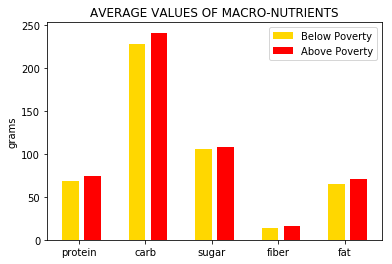

In [14]:
#statistics about average carbs and protein
from matplotlib import pyplot as plt
def addValues(val1, val2):
    return val1 + val2


rich_stat_rdd=rich_nutrient_data.flatMap(lambda x: x[1:])
#print(rich_stat_rdd.take(5))
rich=rich_stat_rdd.reduce(addValues)
average_rich=rich/rich_stat_rdd.count()
#print(rich_stat_rdd.count())
print("For people above poverty line macro-nutrient consumption in grams:")
print("Average protein consumption:",average_rich[0])
print("Average carbohydrate consumption:",average_rich[1])
print("Average fat consumption:",average_rich[4])
print("Average sugar consumption:",average_rich[2])
print("Average fiber consumption:",average_rich[3])

#For people below poverty line
poor_stat_rdd=poor_nutrient_data.flatMap(lambda x: x[1:])
#print(rich_stat_rdd.take(5))
poor=poor_stat_rdd.reduce(addValues)
average_poor=poor/poor_stat_rdd.count()
#print(rich_stat_rdd.count())
print("For people below poverty line macro-nutrient consumption in grams:")
print("Average protein consumption:",average_poor[0])
print("Average carbohydrate consumption:",average_poor[1])
print("Average fat consumption:",average_poor[4])
print("Average sugar consumption:",average_poor[2])
print("Average fiber consumption:",average_poor[3])

bar_list=[]
for i in range(0,5):
    
    bar_list.append(average_poor[i])
print(bar_list)

bar_list1=[]
for i in range(0,5):
    bar_list1.append(average_rich[i])
    

def barPlot(bar_list,bar_list1):
    ind=np.arange(5)
    width=0.25
    fig=plt.figure()
    ax=fig.add_subplot(111)
    rects1=ax.bar(ind,bar_list,width,color='gold')
    rects2=ax.bar(ind+width+0.08,bar_list1,width,color='red')
    ax.set_xticks(ind+width/2)
    ax.set_xticklabels(('protein','carb','sugar','fiber','fat'))
    ax.set_title("AVERAGE VALUES OF MACRO-NUTRIENTS")
    ax.set_ylabel("grams")
    ax.legend((rects1[0],rects2[0]),('Below Poverty','Above Poverty'))
    plt.show()

barPlot(bar_list,bar_list1)


In [16]:
#More stats:

def checkSugar(rdd):
    count=0
    count2=0
    protein=0
    carbs=0
    if(rdd[2]>110):   #checking for people eating dangerous amount of sugar
        count+=1
    if(rdd[4]>100):   #checking for people eating dangerous amount of Fat
        count2+=1
    if(rdd[0]<56):    #checking for people eating deficit amount of protein
        protein+=1
    if(rdd[3]<20):   # fiber
        carbs+=1
    c=np.array((count,count2,protein,carbs))
    return c

totsugfat=rich_stat_rdd.map(checkSugar)

totsugfat1=poor_stat_rdd.map(checkSugar)
#print(totsugfat.take(5))

sugar_sum=totsugfat.reduce(addValues)
sugar_sum1=totsugfat1.reduce(addValues)
percent=sugar_sum1[0]*100/poor_stat_rdd.count()  # sugar poor
percent_rich=sugar_sum[0]*100/rich_stat_rdd.count() #sugar rich
percent_rich_fat=sugar_sum[1]*100/rich_stat_rdd.count() #fat rich
percent_poor_fat=sugar_sum1[1]*100/poor_stat_rdd.count()

########deficit
percent_protein=sugar_sum1[2]*100/poor_stat_rdd.count()  # protien deficit poor
percent_proteinrich=sugar_sum[2]*100/rich_stat_rdd.count()  #protein deficit rich

percent_rich_carbs=sugar_sum[3]*100/rich_stat_rdd.count() #carbs defi rich
percent_poor_carbs=sugar_sum1[3]*100/poor_stat_rdd.count() #carbs defi poor  



print(percent_rich,'percent of people eating dangerous amount of sugars')
print(percent_rich_fat,'percent of people eating dangerous amount of fat')

print("\nfor the people below poverty line\n")
print(percent,'percent of people eating dangerous amount of sugars')
print(percent_poor_fat,'percent of people eating dangerous amount of fat')

print("deficit")
print(percent_protein,"protein deficit in poor" )

print(percent_proteinrich,"protein deficit in rich" )
print(percent_poor_carbs,"fiber deficit in poor" )
print(percent_rich_carbs,"fiber deficit in rich" )



40.607734806629836 percent of people eating dangerous amount of sugars
18.584492284244618 percent of people eating dangerous amount of fat

for the people below poverty line

38.74938453963565 percent of people eating dangerous amount of sugars
15.066469719350074 percent of people eating dangerous amount of fat
deficit
42.319054652880354 protein deficit in poor
34.79710421032578 protein deficit in rich
81.31462333825702 fiber deficit in poor
72.74718994094113 fiber deficit in rich


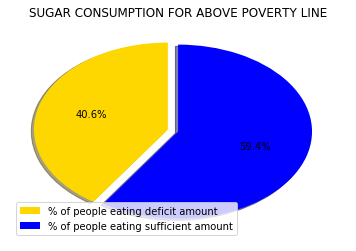

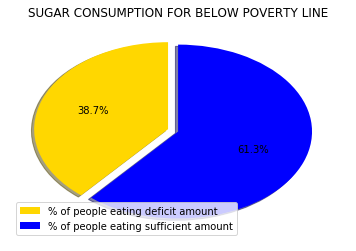

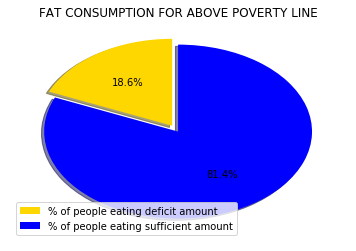

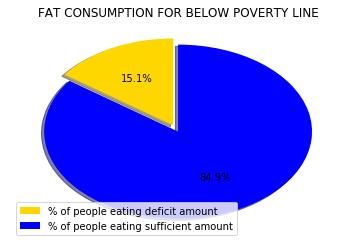

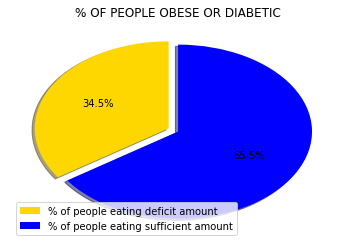

[40.607734806629836, 38.74938453963565, 18.584492284244618, 15.066469719350074]
[59.392265193370164, 61.25061546036435, 81.41550771575538, 84.93353028064993]


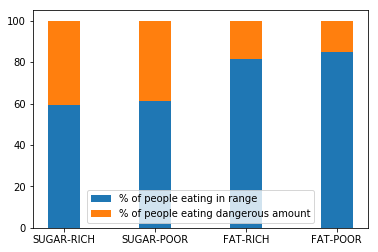

In [17]:
from scipy.stats import normaltest
from pyspark.mllib.clustering import KMeans

def pieChart(percent,title=''):
    stats=[]
    stats.append(percent)
    stats.append(100-percent)
    #print(stats)
    colors=['gold','blue']
    explode=(0.08,0)
    labels=['% of people eating deficit amount','% of people eating sufficient amount']
    plt.pie(stats,explode=explode,colors=colors,autopct='%1.1f%%',shadow=True,startangle=90) 
    plt.legend(labels,loc='best')
    plt.title(title)
    plt.show()    
    
pieChart(percent_rich,'SUGAR CONSUMPTION FOR ABOVE POVERTY LINE')   
pieChart(percent,'SUGAR CONSUMPTION FOR BELOW POVERTY LINE')

pieChart(percent_rich_fat,"FAT CONSUMPTION FOR ABOVE POVERTY LINE")
pieChart(percent_poor_fat,"FAT CONSUMPTION FOR BELOW POVERTY LINE")

obese=34.5
pieChart(obese,"% OF PEOPLE OBESE OR DIABETIC")




#Stacked barplot:
def stackPlot(dataset,dataset1,title=''):
    N=4 
    ind=np.arange(N)
    width=0.35
    p1=plt.bar(ind,dataset,width)
    p2=plt.bar(ind,dataset1,width,bottom=dataset)
    plt.xticks(ind,('SUGAR-RICH','SUGAR-POOR','FAT-RICH','FAT-POOR'))
    plt.legend((p1[0],p2[0]),('% of people eating in range','% of people eating dangerous amount'))
    plt.show()


data_list=[]
data_list1=[]
data_list.append(percent_rich)
data_list.append(percent)

data_list.append(percent_rich_fat)
data_list.append(percent_poor_fat)
#data_list.append
#print(percent_rich)
print(data_list)
data_list1.append(100-percent_rich)
data_list1.append(100-percent)

data_list1.append(100-percent_rich_fat)
data_list1.append(100-percent_poor_fat)
#stackPlot(data,)
print(data_list1)

dataset1=np.array(data_list)
dataset=np.array(data_list1)

stackPlot(dataset,dataset1)




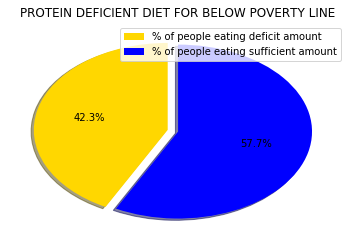

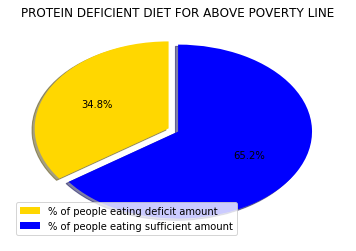

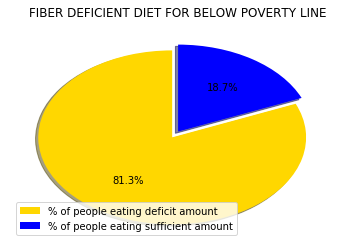

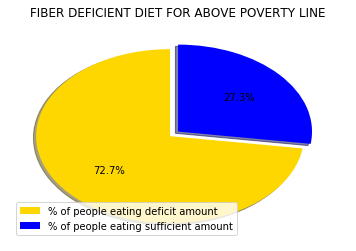

In [18]:
#deficit piechart


pieChart(percent_protein,"PROTEIN DEFICIENT DIET FOR BELOW POVERTY LINE")

pieChart(percent_proteinrich,"PROTEIN DEFICIENT DIET FOR ABOVE POVERTY LINE")

pieChart(percent_poor_carbs,"FIBER DEFICIENT DIET FOR BELOW POVERTY LINE")

pieChart(percent_rich_carbs,"FIBER DEFICIENT DIET FOR ABOVE POVERTY LINE")



[0, 1, 0, 0, 1]
1000
0.14021312394840157


In [19]:

#normalizing and k-means dataset:

#Standardizing 
###final_rich=Standardize(rich_nutrient_data)
final_rich=rich_nutrient_data
###final_poor=Standardize(poor_nutrient_data)
final_poor=poor_nutrient_data
#K-means clustering:

#converting it to (Carb,Fat) pair rdd
def carbFat(rdd):
    rdd=np.array((rdd[1][1],rdd[1][4]))
    return rdd

kmean=final_rich.map(carbFat)
kmean_poor=final_poor.map(carbFat)


###kmean=rich_nutrient_data.map(carbFat)
###kmean_poor=poor_nutrient_data.map(carbFat)

print(kmean_poor.take(5))

print(kmean.take(5))


[array([237.02,  70.54], dtype=float32), array([131.82,  38.94], dtype=float32), array([122.57,  35.63], dtype=float32), array([182.71,  54.6 ], dtype=float32), array([285.6 ,  57.82], dtype=float32)]
[array([199.35, 102.32], dtype=float32), array([274.43,  40.74], dtype=float32), array([303.35, 127.1 ], dtype=float32), array([162.24,  14.17], dtype=float32), array([193.45,  39.89], dtype=float32)]


In [21]:
def plotFoodClusters(data, cluster_ids):
    # Plotting the clusters with a scatter plot
   
    data = np.array(data.collect())
    plt.scatter(data[:,0], data[:,1], c=cluster_ids, s=1)

    plt.xlabel('Grams of Carbohydrate')
    plt.ylabel('Grams of Fat')
    plt.title('Food intake Clusters with k-Means')
    plt.show()
    plt.clf()



def clusterAndPlotData(data, K):
    
    model = KMeans.train(data, K, maxIterations=10, initializationMode='random')
    
    cluster_ID=model.predict(data).collect()
    print(model.clusterCenters)
    
    plotFoodClusters(data,cluster_ID)


#sampling the data set to compare the clusters
kmean1=kmean.sample(False,0.45)
#kmean1=kmean
print(kmean1.count())
print(kmean_poor.count())


4736
4062


[18912454.95261123, 13990040.211914182, 11966954.622753711, 9982585.116523892, 8577505.33907818, 8972171.77402436, 7320503.494940581, 6578309.021163483]
[16753618.086126618, 12195261.513562588, 10209513.27394751, 8560566.839308653, 7270346.604125099, 7666072.560799941, 6183734.503900623, 5586473.746270511]


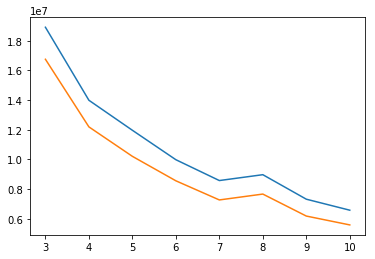

In [22]:
from matplotlib import pyplot as plt


wsse=[]
wsse1=[]
k_vals=[]
for k in range(3,11):
    model = KMeans.train(kmean1, k, maxIterations=10, initializationMode='random')
    model1 = KMeans.train(kmean_poor, k, maxIterations=10, initializationMode='random')
    k_vals.append(k)
    
    wsse.append(model.computeCost(kmean1))
    wsse1.append(model.computeCost(kmean_poor))
    
# Plot the WSSSE for different values of k
print(wsse)
print(wsse1)
plt.plot(k_vals,wsse)
plt.plot(k_vals,wsse1)
plt.show()



[array([345.68790706,  95.6254574 ]), array([524.74795961, 140.71836173]), array([132.36431293,  43.79912273]), array([233.15566086,  68.50555669])]


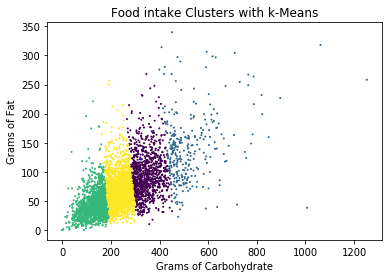

[array([102.82780676,  34.44843474]), array([489.26064643, 134.09929621]), array([303.28942366,  82.29625191]), array([194.1699254 ,  55.47585598])]


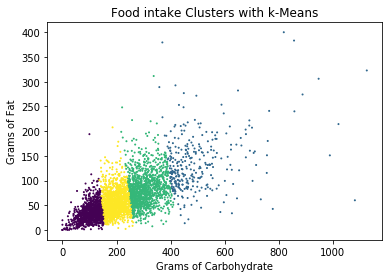

In [26]:
#plotting the clusters using K-means: 

clusterAndPlotData(kmean1, 4)
clusterAndPlotData(kmean_poor,4)